# Calculate PES for CO2 (exact and vqe)
https://qiskit.org/ecosystem/nature/howtos/vqe_ucc.html

In [1]:
#imports
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.mappers import QubitConverter

from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.formats import MoleculeInfo

import numpy as np
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms.minimum_eigensolvers import VQE
#from qiskit.primitives import Estimator

from qiskit_aer.primitives import Estimator

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit.opflow import TwoQubitReduction

from qiskit_nature import settings
settings.use_pauli_sum_op = False

from qiskit.utils import algorithm_globals

from qiskit.circuit.library import EfficientSU2

from qiskit import BasicAer

In [2]:
# create mapper
mapper = JordanWignerMapper()

In [3]:
# create initial problem to determine parameters for ansatz -> unoptimized
dist = 0.735

#["Mn", [0.0, 0.0, 0.0]],
#["O", [dist, 0.0, 0.0]],
#["C", [dist + 1.17, 0.0, 0.0]],   
#["O", [dist + 2.34, 0.0, 0.0]]

atom_str = "Mn 0.0 0.0 0.0; O {0} 0.0, 0.0 C {1} 0.0 0.0 O {2} 0.0 0.0".format(dist, dist+1.17, dist+2.34)

print(atom_str)
driver = PySCFDriver(atom=atom_str, charge=2, spin=3, basis="sto-3g")
problem = driver.run()

num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

print("Particles and orbitals for MnCO2: ", num_particles, " ", num_spatial_orbitals)

Mn 0.0 0.0 0.0; O 0.735 0.0, 0.0 C 1.9049999999999998 0.0 0.0 O 3.0749999999999997 0.0 0.0
Particles and orbitals for MnCO2:  (17, 14)   23


In [4]:
#create ansatz initial
ansatz_init = UCCSD(
    num_spatial_orbitals,
    num_particles,
    mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper,
    ),
)

KeyboardInterrupt: 

In [5]:
# now you want to apply the freeze-core reduction
transformer = FreezeCoreTransformer(freeze_core=True,
                                    remove_orbitals=[-4,-3,-2, -1])

reduced_problem = transformer.transform(problem)

num_spatial_orbitals = reduced_problem.num_spatial_orbitals
num_particles = reduced_problem.num_particles
print("Reduced Particles and orbitals for MnCO2: ", num_particles, " ", num_spatial_orbitals)

#create ansatz freeze-core
ansatz_freeze_core = UCCSD(
    num_spatial_orbitals,
    num_particles,
    mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper,
    ),
)

Reduced Particles and orbitals for MnCO2:  (10, 5)   13


In [6]:
# now lets adapt active space, more or less reducing to crap
as_transformer = ActiveSpaceTransformer(num_electrons=problem.num_particles, num_spatial_orbitals=5)

as_problem = as_transformer.transform(problem)
num_spatial_orbitals = as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
print("Active space reduced Particles and orbitals for MnCO2: ", num_particles, " ", num_spatial_orbitals)
# optimize ansatz -> make HW-efficient
ansatz_active_space = EfficientSU2(num_qubits=num_spatial_orbitals, reps=1, entanglement='linear', insert_barriers=True)
init_state_active_space = np.random.random(ansatz_active_space.num_parameters*2)

Active space reduced Particles and orbitals for MnCO2:  (5, 5)   5


In [7]:
#print(f"Initial ansatz depth = {ansatz_init.depth()}, num_qubits= {ansatz_init.num_qubits}")
print(f"FreezeCore ansatz depth = {ansatz_freeze_core.depth()}, num_qubits= {ansatz_freeze_core.num_qubits}")
print(f"Active space ansatz depth = {ansatz_active_space.depth()}, num_qubits= {ansatz_active_space.num_qubits}")

FreezeCore ansatz depth = 1, num_qubits= 26
Active space ansatz depth = 1, num_qubits= 5


In [8]:
#create problem by dist
def create_problem(dist):
    atom_str = "Mn 0.0 0.0 0.0; O {0} 0.0, 0.0 C {1} 0.0 0.0 O {2} 0.0 0.0".format(dist, dist+1.17, dist+2.34)
    #print(atom_str)
    driver = PySCFDriver(atom=atom_str, charge=2, spin=3, basis="sto-3g")
    problem = driver.run()
    
    #reduce problem
    # now you want to apply the freeze-core reduction
    as_transformer = ActiveSpaceTransformer(num_electrons=problem.num_particles, num_spatial_orbitals=5)
    as_problem = as_transformer.transform(problem)

    #transformer = FreezeCoreTransformer(freeze_core=True,
    #                                    remove_orbitals=[-4,-3,-2, -1])
    #
    #reduced_problem = transformer.transform(problem)    
    
    return as_problem

In [9]:
ansatz = ansatz_active_space
init_state = init_state_active_space
hw_efficient = True
exact_solution = False

In [10]:
# build vqe
estimator = Estimator(run_options= {"method": "statevector"})
vqe = VQE(estimator, ansatz, SLSQP(maxiter=100))

In [11]:
distances = np.arange(0.2, 1.5, 0.1)

In [12]:
exact_energies = []
vqe_energies = []

num_evals = 0

np.random.seed(5)
algorithm_globals.random_seed = 5

In [13]:
for dist in distances:
    problem = create_problem(dist)
    
    # set initialpoint to Harttreefock for problem
    if hw_efficient == True:
        vqe.initial_point = init_state
    else:
        initial_point = HFInitialPoint()
        initial_point.ansatz = ansatz
        initial_point.problem = problem
        vqe.initial_point = initial_point.to_numpy_array()

    # solve exact ?
    if exact_solution == True:
        algo = NumPyMinimumEigensolver()
        algo.filter_criterion = problem.get_default_filter_criterion()

        solver = GroundStateEigensolver(mapper, algo)
        result = solver.solve(problem)
        exact_energies.append(result.total_energies[0].real)
        print(f"Dist: {dist:.2f}, Total ground state energy = {result.total_energies[0]:.4f}")
    
    # solve vqe
    fermionic_op = problem.hamiltonian.second_q_op()  # Get fermionic_op
    
    qubit_op = mapper.map(fermionic_op)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    num_evals += vqe_calc.cost_function_evals
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    
    print(f"Dist: {dist:.2f}, Total vqe energy = {vqe_result:.4f}")   

Dist: 0.20, Total vqe energy = -322.3789
Dist: 0.30, Total vqe energy = -471.2996
Dist: 0.40, Total vqe energy = -511.7488
Dist: 0.50, Total vqe energy = -544.1550
Dist: 0.60, Total vqe energy = -550.8144
Dist: 0.70, Total vqe energy = -563.3243
Dist: 0.80, Total vqe energy = -584.2991
Dist: 0.90, Total vqe energy = -572.6656
Dist: 1.00, Total vqe energy = -582.2544
Dist: 1.10, Total vqe energy = -565.2977
Dist: 1.20, Total vqe energy = -576.3658
Dist: 1.30, Total vqe energy = -565.5454
Dist: 1.40, Total vqe energy = -581.3188


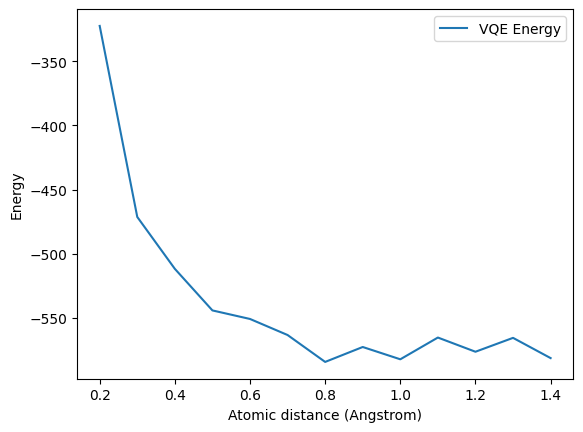

In [16]:
if exact_solution == True:
    plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

# Compare results

![PES_MnCO2.jpg](attachment:PES_MnCO2.jpg)

From quantistry

In [15]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright